# This notebook is to plot geographical density of SCS counts over a given season:

In [1]:
### Importing necessary packages
import pandas as pd
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

In [2]:
TIMEZONE_MAP = {
    # Eastern
    "EST": "US/Eastern", "EST-5": "US/Eastern", "EDT": "US/Eastern",
    "E": "US/Eastern", "ET": "US/Eastern",

    # Central
    "CST": "US/Central", "CST-6": "US/Central", "CDT": "US/Central",
    "C": "US/Central", "CT": "US/Central",

    # Mountain
    "MST": "US/Mountain", "MST-7": "US/Mountain", "MDT": "US/Mountain",
    "M": "US/Mountain", "MT": "US/Mountain",

    # Pacific
    "PST": "US/Pacific", "PST-8": "US/Pacific", "PDT": "US/Pacific",
    "P": "US/Pacific", "PT": "US/Pacific",

    # Alaska / Hawaii / Atlantic
    "AKST": "US/Alaska", "AST": "US/Alaska",  # AST can be Atlantic; check state if needed
    "HST": "US/Hawaii", "HAWAII": "US/Hawaii",
    "AST-4": "America/Puerto_Rico", "ATLANTIC": "America/Puerto_Rico"
}


def build_begin_datetime(df: pd.DataFrame) -> pd.Series:
    """
    Build a reliable datetime from BEGIN_YEARMONTH (YYYYMM),
    BEGIN_DAY, BEGIN_TIME (HHMM). Coerces bad values to NaT.
    """
    yyyymm = df["BEGIN_YEARMONTH"].astype("Int64").astype(str)
    day = df["BEGIN_DAY"].astype("Int64").astype(str).str.zfill(2)

    time = (
        df["BEGIN_TIME"]
        .astype("Int64")
        .fillna(0)
        .astype(str)
        .str.zfill(4)
    )

    dt_str = yyyymm + day + time
    return pd.to_datetime(dt_str, format="%Y%m%d%H%M", errors="coerce")


def standardize_and_convert_to_utc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the dataframe with 'BEGIN_DT' (naive) and 'CZ_TIMEZONE',
    converts to UTC taking into account DST transitions.
    """
    df['clean_tz'] = df['CZ_TIMEZONE'].str.upper().str.strip().map(TIMEZONE_MAP)
    df['clean_tz'] = df['clean_tz'].fillna('UTC')

    utc_chunks = []

    for tz_name, group in df.groupby('clean_tz'):
        if tz_name == 'UTC':
            converted = group['BEGIN_DT'].dt.tz_localize('UTC')
        else:
            localized = group['BEGIN_DT'].dt.tz_localize(
                tz_name,
                ambiguous='NaT',
                nonexistent='shift_forward'
            )
            converted = localized.dt.tz_convert('UTC')

        group['BEGIN_DT_UTC'] = converted
        utc_chunks.append(group)

    df_utc = pd.concat(utc_chunks).sort_index()
    return df_utc.drop(columns=['clean_tz'])

In [3]:
# Loading in the data
data_dir = Path("/data1/lepique/stormevents_details/")  # adjust if needed
pattern = "StormEvents_details-ftp_v1.0_d*_c*.csv.gz"

storm_types = {"Tornado", "Hail", "Thunderstorm Wind"}
winter_months = {12, 1, 2, 3}

# Keeping only variables of immediate interest (can modify if needed)
keep_cols = [
    "EVENT_ID", "EPISODE_ID", "EVENT_TYPE",
    "BEGIN_DT",
    "STATE", "WFO",
    "BEGIN_LAT", "BEGIN_LON",
    "MAGNITUDE", "MAGNITUDE_TYPE",
]

files = sorted(data_dir.glob(pattern))
print(f"Found {len(files)} files")

dfs = []

for fp in files:
    m = re.search(r"_d(\d{4})_", fp.name)
    year = int(m.group(1)) if m else None

    print(f"Reading {fp.name} (year={year})")

    df = pd.read_csv(fp, compression="gzip", low_memory=False)

    # Ensure datetime is datetime
    df["BEGIN_DT"] = build_begin_datetime(df)
    df = df.dropna(subset=["BEGIN_DT"])

    # Drop rows with missing begin time (safer for dt.month)
    df = df.dropna(subset=["BEGIN_DATE_TIME"])

    # DJFM filter
    df = df[df["BEGIN_DT"].dt.month.isin(winter_months)]

    # December-year winter label
    dt = df["BEGIN_DT"]
    df["WINTER_SEASON"] = dt.dt.year - dt.dt.month.isin(winter_months).astype(int)

    # Storm-type filter
    df = df[df["EVENT_TYPE"].isin(storm_types)]

    # Optional: keep only selected columns
    # cols = ["WINTER_SEASON"] + keep_cols
    # df = df[cols].copy()

    # Optional: source file year
    df["SOURCE_FILE_YEAR"] = year

    dfs.append(df)

# Concatenate all years
df_winter_scs = pd.concat(dfs, ignore_index=True)

# Eliminate JFM 1950 because full winter season is not available
df_winter_scs = df_winter_scs[df_winter_scs["WINTER_SEASON"] >= 1950]

# Add UTC time column
df_winter_scs = standardize_and_convert_to_utc(df_winter_scs)

print("Done.")
print(df_winter_scs.shape)
print(df_winter_scs["EVENT_TYPE"].value_counts())
print(df_winter_scs["WINTER_SEASON"].min(), df_winter_scs["WINTER_SEASON"].max())

Found 76 files
Reading StormEvents_details-ftp_v1.0_d1950_c20250520.csv.gz (year=1950)
Reading StormEvents_details-ftp_v1.0_d1951_c20250520.csv.gz (year=1951)
Reading StormEvents_details-ftp_v1.0_d1952_c20250520.csv.gz (year=1952)
Reading StormEvents_details-ftp_v1.0_d1953_c20250520.csv.gz (year=1953)
Reading StormEvents_details-ftp_v1.0_d1954_c20250520.csv.gz (year=1954)
Reading StormEvents_details-ftp_v1.0_d1955_c20250520.csv.gz (year=1955)
Reading StormEvents_details-ftp_v1.0_d1956_c20250520.csv.gz (year=1956)
Reading StormEvents_details-ftp_v1.0_d1957_c20250520.csv.gz (year=1957)
Reading StormEvents_details-ftp_v1.0_d1958_c20250520.csv.gz (year=1958)
Reading StormEvents_details-ftp_v1.0_d1959_c20250520.csv.gz (year=1959)
Reading StormEvents_details-ftp_v1.0_d1960_c20250520.csv.gz (year=1960)
Reading StormEvents_details-ftp_v1.0_d1961_c20250520.csv.gz (year=1961)
Reading StormEvents_details-ftp_v1.0_d1962_c20250520.csv.gz (year=1962)
Reading StormEvents_details-ftp_v1.0_d1963_c20250

In [4]:
# Choose the DJFM winter season (December-year label)
# Example: 2010 means Dec 2010 – Mar 2011
season = 2010

season_subset = df_winter_scs[df_winter_scs["WINTER_SEASON"] == season]
print(f"Total DJFM reports in winter season {season}: {len(season_subset)}")
print(season_subset["EVENT_TYPE"].value_counts())

Total DJFM reports in winter season 2010: 3068
EVENT_TYPE
Thunderstorm Wind    1442
Hail                 1435
Tornado               191
Name: count, dtype: int64


In [5]:
def plot_season_density(df, season, event_type, bins=60):
    """
    Full-US cartopy map for one winter season and hazard type.
    Uses same projection/extent as plot_case, but shades density.
    """
    # Filter to this season + hazard
    et = df["EVENT_TYPE"].str.upper().fillna("OTHER")
    if event_type.lower().startswith("tornado"):
        mask = et.str.contains("TORNADO")
        cmap = "Reds"
    elif event_type.lower().startswith("hail"):
        mask = et.str.contains("HAIL")
        cmap = "Greens"
    else:  # Thunderstorm Wind
        mask = et.str.contains("THUNDERSTORM WIND") | et.str.contains("TSTM WIND")
        cmap = "Blues"

    season_df = df[(df["WINTER_SEASON"] == season) & mask].copy()
    season_df = season_df.dropna(subset=["BEGIN_LAT", "BEGIN_LON"])

    if season_df.empty:
        print(f"No {event_type} reports for WINTER_SEASON={season}")
        return

    # Same projection and CONUS extent as plot_case
    proj = ccrs.LambertConformal(
        central_longitude=-96, central_latitude=39,
        standard_parallels=(33, 45),
    )
    extent = [-130, -65, 23, 50]

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=proj)
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Basemap features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.4)
    ax.set_facecolor("white")

    # Fixed grid over CONUS to avoid weird artifacts
    lon_min, lon_max, lat_min, lat_max = extent
    lon_bins = np.linspace(lon_min, lon_max, bins + 1)
    lat_bins = np.linspace(lat_min, lat_max, bins + 1)

    H, lon_edges, lat_edges = np.histogram2d(
        season_df["BEGIN_LON"].values,
        season_df["BEGIN_LAT"].values,
        bins=[lon_bins, lat_bins],
    )

    # Mask zero-count cells so background stays clean
    H_masked = np.ma.masked_where(H.T == 0, H.T)

    pcm = ax.pcolormesh(
        lon_edges,
        lat_edges,
        H_masked,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading="auto",
    )
    pcm.cmap.set_bad("none")  # masked cells transparent

    cb = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02, shrink=0.7)
    cb.set_label("Report count per grid cell")

    ax.set_title(f"{event_type} density\nDJFM winter season {season}", fontsize=13)
    plt.tight_layout()
    plt.show()

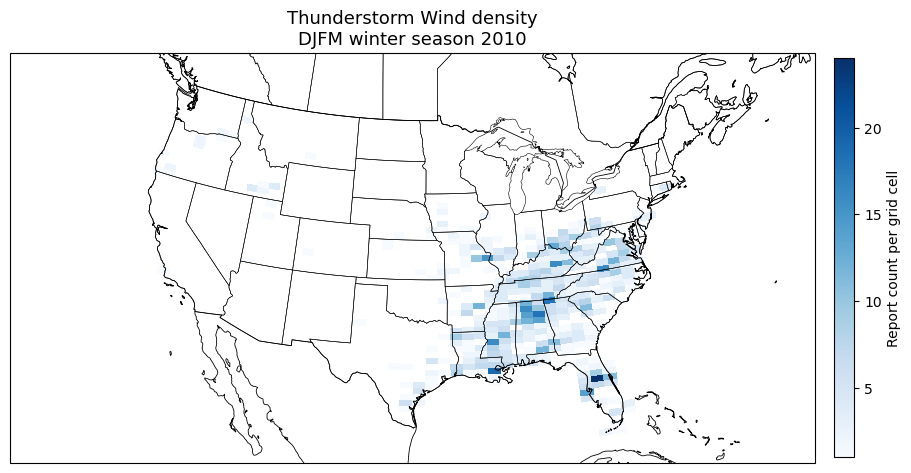

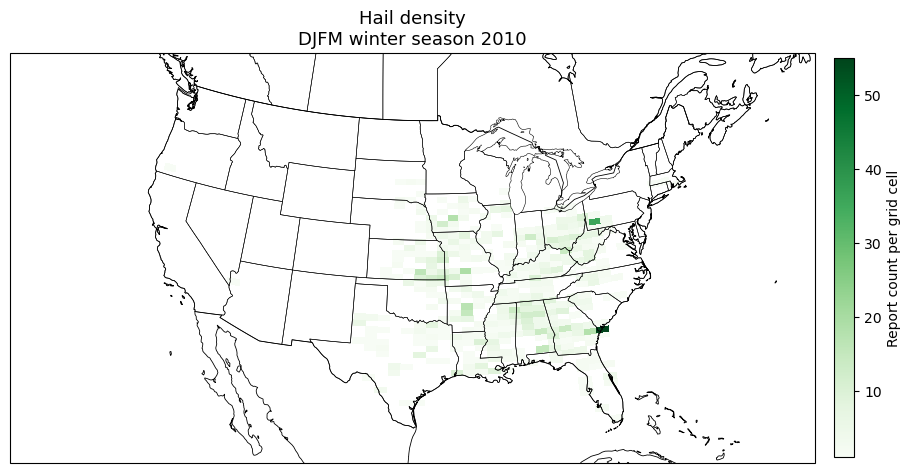

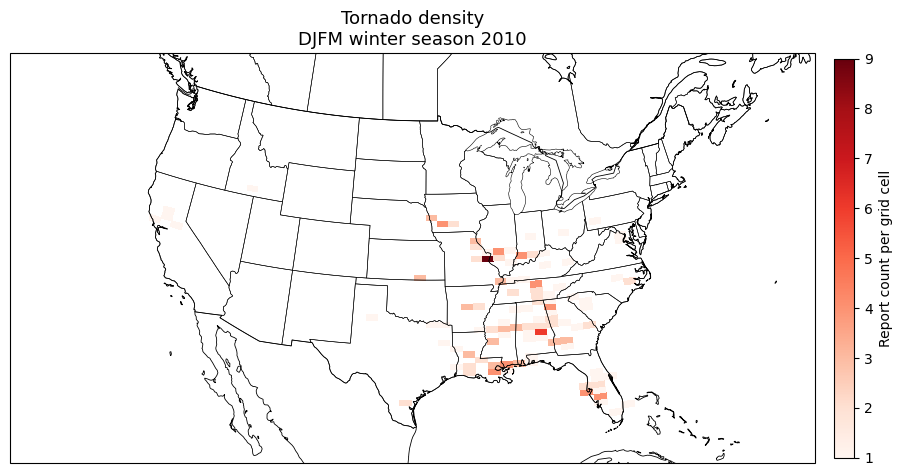

In [6]:
season = 2010  # e.g., Dec 2010–Mar 2011

for hazard in ["Thunderstorm Wind", "Hail", "Tornado"]:
    plot_season_density(df_winter_scs, season=season, event_type=hazard, bins=60)

In [7]:
df_winter_scs.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'BEGIN_DT',
       'WINTER_SEASON', 'SOURCE_FILE_YEAR', 'BEGIN_DT_UTC'],
      dtype='object')

In [12]:
np.unique_counts((df_winter_scs['CZ_TYPE']))

UniqueCountsResult(values=array(['C', 'Z'], dtype=object), counts=array([109227,     42]))

In [13]:
## subsetting to only counties and not marine zones
df_winter_scs = df_winter_scs[df_winter_scs["CZ_TYPE"] == "C"]

In [ ]:
##Converting state and county FIPS codes to strings so that I can combine them together to create unique COUNTY_FIPS codes
df_winter_scs =df_winter_scs[df_winter_scs["CZ_TYPE"] == "C"].copy()

df_winter_scs["STATE_FIPS"] = (
   df_winter_scs["STATE_FIPS"]
    .astype(float)
    .astype(int)
    .astype(str)
    .str.zfill(2)
)

df_winter_scs["CZ_FIPS"] = (
   df_winter_scs["CZ_FIPS"]
    .astype(float)
    .astype(int)
    .astype(str)
    .str.zfill(3)
)

df_winter_scs["COUNTY_FIPS"] = (
   df_winter_scs["STATE_FIPS"] +df_winter_scs["CZ_FIPS"]
)

In [ ]:
#Verification:
print(df_winter_scs['COUNTY_FIPS'].iloc[0])
print(df_winter_scs["COUNTY_FIPS"].str.len().unique())

48225
[5]


In [29]:
county_counts = (
    df_winter_scs.groupby(["COUNTY_FIPS","EVENT_TYPE"]
    .size()
    .reset_index(name="count")
))

AttributeError: 'list' object has no attribute 'size'

In [27]:
county_counts

,COUNTY_FIPS,count
0,01000,7
1,01001,111
2,01003,173
3,01005,80
4,01007,79
...,...,...
2897,99111,1
2898,99127,6
2899,99133,1
2900,99139,1
